In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack

Imported MigPreFuncoes now
Imported SlantStack now


*******

Frequência da Wavelet: $f_{r} = 40$ Hz

Velocidade constante do modelo: $c = 250$ m/s

$v = \lambda \cdot f$

Para nossa barra estar abaixo do limite de resolução definido entre $\lambda/2$ e $\lambda/4$, temos que definir a largura da barra como 

$ \lambda = \dfrac{v}{f} = \dfrac{250}{40} = 6.25 $ m

$ \lambda/2 \approx 3 \iff  \lambda/4 \approx 1.5 $

********

In [203]:
dx=1.0 #(m) Discretização em X
dz=1.0 #(m) Discretização em Y
#dt=0.8 #(s)
nz=120 #Tamanho do Grid em 
ntr=nx=240
c=250 #m/s

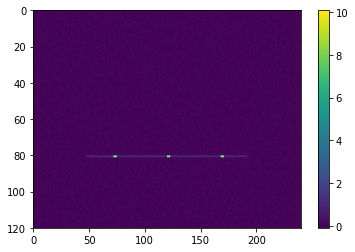

In [255]:
MOD = np.zeros([ntr,nz])

#Barra
x_ini_1 = int(np.round(1*ntr/5))
x_fim_1 = int(np.round(4*ntr/5))

#Pontos Difratores
for i in range(x_ini_1,x_fim_1):
    z = int(np.round(nz*2/3))
    MOD[i,z]=1
MOD[int(np.round(1.5*nx/5)):int(np.round(1.5*nx/5+3)),z]=10
MOD[int(np.round(2.5*nx/5)):int(np.round(2.5*nx/5+3)),z]=10
MOD[int(np.round(3.5*nx/5)):int(np.round(3.5*nx/5+3)),z]=10

#Adicionando ruído no modelo
nn = np.random.rand(ntr,nz)
MOD = MOD+(nn-0.5)*0.2

R = MOD.T

plt.imshow(MOD.T, aspect="auto", extent=[0,dx*ntr,nz*dz,0])
plt.colorbar()
plt.show()

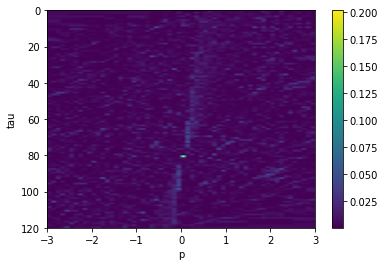

In [256]:
# Detectando as inclinações presentes no modelo
pmin=-3
pmax=3
dp=0.1

S,pmaxS,taumaxS,smax,ip,itau = SlantStack.slant_stack(pmin,pmax,dp,0,nz*dz,dz,MOD.T,dx,dz,0,0)

plt.imshow(S,extent=[pmin,pmax,nz*dz,0],aspect="auto")
plt.colorbar()
plt.xlabel('p')
plt.ylabel('tau')
plt.show()

In [257]:
t1 = np.degrees(np.arctan(pmaxS))
print("pmax MOD1 =", pmaxS)
print(f"theta 1 = {t1} graus")

pmax MOD1 = 2.6645352591003757e-15
theta 1 = 1.526666247102488e-13 graus


(120, 240)


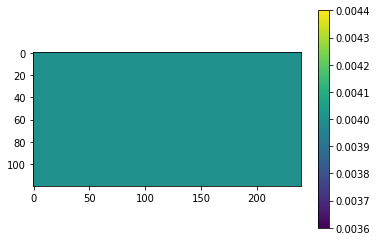

In [258]:
#Modelo de Vagarosidade SW
#c = 250
# Checar pq não estamos calculando tmax antes dessa célula
SW=np.ones([nz,ntr])*1/c
print(SW.shape)

plt.imshow(SW)
plt.colorbar()
plt.show()

In [271]:
#Tabela de tempo de trânsito do modelo de vagarosidade SW

TT=MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/time_table_barra.npy")

TTh.shape=(240, 120, 240)


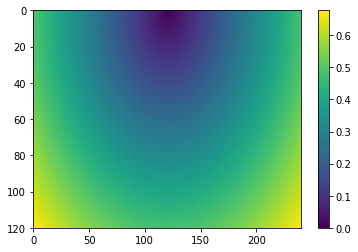

TSX.shape=(120, 240)


In [273]:
with open('Data/time_table_barra.npy', 'rb') as f:
    TTh = np.load(f)

print(f"TTh.shape={TTh.shape}")

dt=0.004

TSX = (TTh[120,:,:])  # Traveltime  (indexes)
plt.imshow(TSX,extent=[0, ntr*dx, nz*dz, 0], aspect='auto')
plt.colorbar()
plt.show()

timer=np.round(TTh/dt)+1

print(f"TSX.shape={TSX.shape}")

In [274]:
dt=0.004
print(1/2/dt)

125.0


2.146625258399798


Text(0.5, 0, 's')

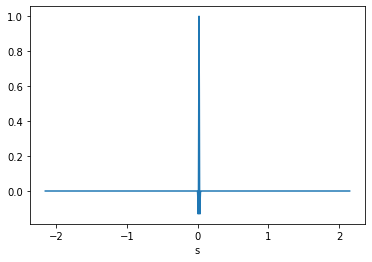

In [277]:
#Wavelet

fr=40 #Hz
nps=200 #era 200, mudei pra 136 e funcionou, 
#       #tenho que conferir se posso fazer isso mesmo...
dt=.004 #s
rick=MigPreFuncoes.ricker(nps,fr,dt)

#sx=10  #index position
#sz=0  #index position

# Tempo de ida e volta até o fundo do modelo
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
print(tmax)
#nd2=nt+1; 



W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1]


plt.plot(np.arange(-nt*dt,nt*dt,dt),W)
plt.xlabel('s')

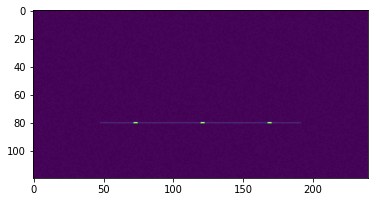

In [278]:
nx=ntr

#Modelo:
R = MOD.T

plt.imshow(R)
plt.show()

In [279]:
#### Create file with all shot gathers
#
nsx=nx #105  #numero de tiros (pode ser no máximo o valor de TTh axis=0)
ngx=nx #105   #numero de receptores (pode ser no máximo o valor de TTh axis=1)
##Loop over shots
#
for isx in range(119,122,1):
    print('shot', isx)
    D = np.zeros([nt,ngx])
    TSX = (TTh[isx,:,:]/dt+1).astype(int)  # Traveltime  (indexes)

#
#    # Loop Over Traces
    for gx in range(0,ngx):
        TXG=(TTh[gx,:,:]/dt+1).astype(int)  # Traveltime in heterogeneous medium (indexes)
                         
      
        #Loop over time sample in a trace
        for t in range(0,nt):
            M=W[t-(TSX+TXG)+nt+1]*R
            #D[t,gx]=np.sum(M.flatten('F'));
            D[t,gx]=np.sum(M.flatten());
        gather1=np.diff(D[:,:],n=2,axis=0);
        
    filename = 'Data/CSG_diffbar/barra_gather_shotCenter{}'.format(isx)
    print(filename)
    with open(filename, 'wb') as f:
        np.save(f, gather1)

shot 119
Data/CSG_diffbar/barra_gather_shotCenter119
shot 120
Data/CSG_diffbar/barra_gather_shotCenter120
shot 121
Data/CSG_diffbar/barra_gather_shotCenter121


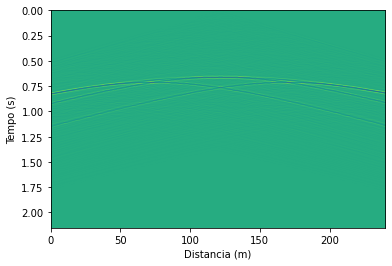

In [281]:
#plt.imshow(np.diff(D[:,:],n=2,axis=0),aspect='auto',extent=[0, nx*dx, nt*dt, 0])
plt.imshow(np.diff(D[:,:],n=2,axis=0),aspect='auto',interpolation='bilinear', 
           extent=[0, nx*dx, nt*dt, 0])
plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
#plt.ylim([1.0,0])
plt.show()

In [282]:
files = []

for i in range(119,122,1):
    filename = 'Data/CSG_diffbar/barra_gather_shotCenter{}'.format(i)
    print(i,filename)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)
        
len(files)

119 Data/CSG_diffbar/barra_gather_shotCenter119
120 Data/CSG_diffbar/barra_gather_shotCenter120
121 Data/CSG_diffbar/barra_gather_shotCenter121


3

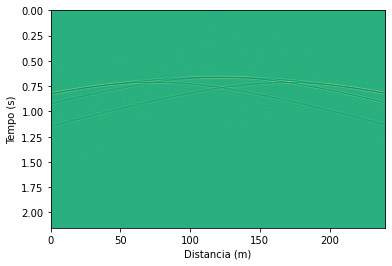

In [283]:
plt.imshow(files[1],aspect='auto',extent=[0, nx*dx, nt*dt, 0])

plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
#plt.ylim([0.4,0])
plt.show()

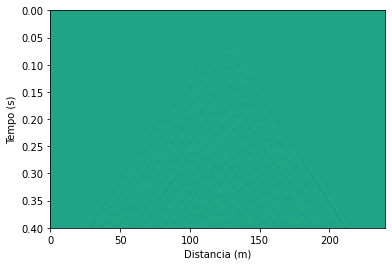

In [284]:
G2=MigPreFuncoes.phase_shift(files[1])
plt.imshow(G2,aspect='auto',extent=[0, nx*dx, nt*dt, 0])

plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.ylim([0.4,0])
plt.show()

538


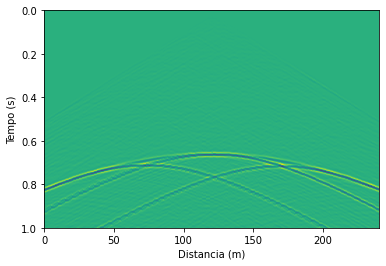

In [285]:
shot = 120
filename = 'Data/CSG_diffbar/barra_gather_shotCenter{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

#nt=500
print(nt)
gather1=gather1t[0:nt,:]
win=20*dt
dwin=dt
app=15
isx=shot


plt.imshow(gather1,aspect='auto',extent=[0, nx*dx, nt*dt, 0])
plt.ylim([1,0])
plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.show()

# Slant Stack

#Transformar em célula de código se não tiver o aruivo salvo localmente

xwin=twin=25
m_taumax,m_pmax, s_max = SlantStack.local_window(MOD.T,xwin,twin,dx,dt)

with open("Data/CSG_diffbar/janela_barra", "wb") as f:
    np.save(f, m_pmax)

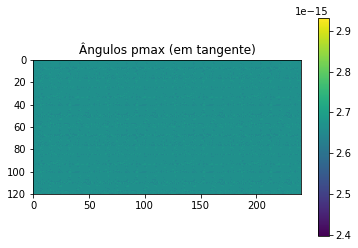

In [286]:
with open("Data/CSG_diffbar/janela_barra", "rb") as f:
    tst = np.load(f)

#plt.figure(figsize=(5,6))
plt.imshow(tst,extent=[0, ntr*dx, nz*dz, 0])
plt.title("Ângulos pmax (em tangente)")
plt.colorbar()
plt.show()

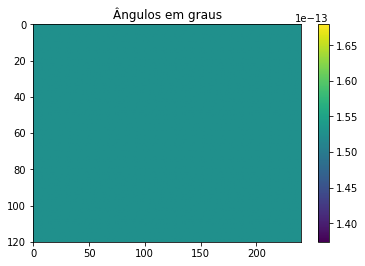

In [287]:
m_theta = np.degrees(np.arctan(tst))
plt.imshow(m_theta,extent=[0, ntr*dx, nz*dz, 0], aspect="auto")
plt.title("Ângulos em graus")
plt.colorbar()
plt.show()

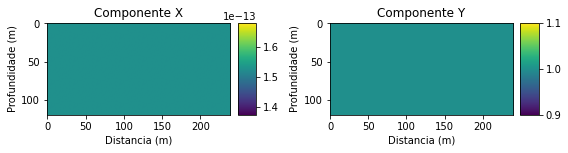

In [288]:
X = np.sin(m_theta)
Y = np.cos(m_theta)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

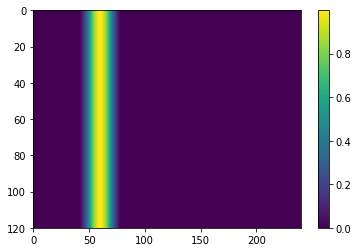

In [289]:
igx=0
app=20
trace_app = MigPreFuncoes.taper(ntr,nz,app,isx,igx) 
plt.imshow(trace_app,extent=[0, ntr*dx, nz*dz, 0], aspect="auto")
plt.title("")
plt.colorbar()
plt.show()

Imported MigPreFuncoes now
1.0 1.0
120 1.0 1.0 0.004 0.04 0.004 40
gather shape is  (536, 240)
TTh shape is  (240, 120, 240)


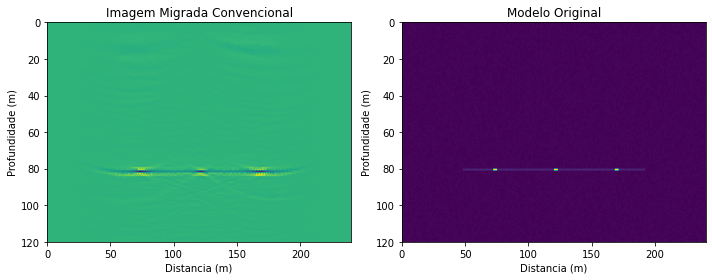

In [292]:
import importlib
#import MigPreFuncoes
importlib.reload(MigPreFuncoes)

print(dx,dz)
win=10*dt #(metade)janela em tempo em cada etapa
dwin=dt

app=40 # abertura em traços

print(isx,dx,dz,dt,win,dwin,app)
print('gather shape is ', gather.shape)
print('TTh shape is ', TTh.shape)
epsilon=1.0  # frequency dependent
mig_winapp = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,
                                         win,dwin,app,TTh,X,Y, epsilon)


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_winapp, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [293]:
#falta rodar a partir daqui

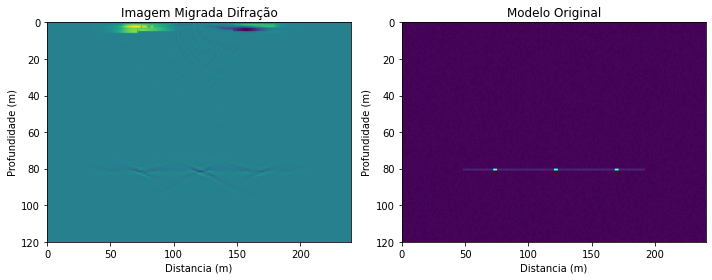

In [294]:
mig_diff = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Difração")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
#Stack

mig_stack = MigPreFuncoes.migstack_winapp(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_stack_diff = MigPreFuncoes.migstack_winapp_diff(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()